<a href="https://colab.research.google.com/github/salazarvalverdefd/ProjectFindPet/blob/main/src/Inceptionv3_CNN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
PATH_ORIGEN = "/content/drive/MyDrive/Proyecto-MINSA/Dataset/Clasificacion/HGG-LGG"
os.chdir(PATH_ORIGEN)

In [ ]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from random import shuffle
import sys
import tensorflow_addons as tfa

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 155
NUM_FEATURES = 2048
VALIDATION_SPLIT = 0.1
NUM_CLASSES = 2

In [ ]:
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            #frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:

def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
in_dir = "/content/drive/MyDrive/Proyecto-MINSA/Dataset/Clasificacion/HGG-LGG/AVI"

In [ ]:
def label_video_names(in_dir):
    """
    Funcion que categoriza los datos(videos) de acuerdo al nombre que llevan
    Parameters
    ----------
    in_dir : carpeta donde se encuentran los videos.
    Returns
    -------
    names : lista que contiene los nombres de los videos
    labels : lista que contiene la categoria de los video,
    ya sea (1 = HGG) o (0=LGG).
    """
    names = []
    labels = []
    
    for _ , _ , file_names in os.walk(in_dir):
      for file_name in file_names:
          
        if file_name[0:3] == 'HGG':
            labels.append([1,0])
            names.append(file_name)
            
        elif file_name[0:3] == 'LGG':
            labels.append([0,1])
            names.append(file_name)      
    
    c = list(zip(names,labels)) 
    shuffle(c)
    names, labels = zip(*c)
            
    return names, labels
def print_progress(count, max_count):
    
    # Porcentaje de completado.
    pct_complete = count / max_count
    msg = "\r- Progreso: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

In [ ]:
def prepare_all_videos(in_dir):
    video_paths, labels = label_video_names(in_dir)
    num_samples = len(video_paths)
    labels = np.array(labels, dtype="float32")
    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(in_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()
        print_progress(idx+1, num_samples)
        

    return (frame_features, frame_masks), labels

In [ ]:

data, labels = prepare_all_videos(in_dir)
np.save('./inceptionV3/data.npy',data[0])
np.save('./inceptionV3/masks.npy',data[1])
np.save('./inceptionV3/labels.npy',labels)
print()
print(f"Frame features: {data[0].shape}")
print(f"Frame masks: {data[1].shape}")

- Progreso: 100.0%
Frame features: (369, 155, 2048)
Frame masks: (369, 155)
CPU times: user 1h 13min 59s, sys: 2min 12s, total: 1h 16min 11s
Wall time: 1h 22min 32s


In [ ]:
# Utility for our sequence model.
def get_sequence_model():

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    """rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )"""
    rnn_model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = os.path.join(PATH_ORIGEN, 'inceptionV3')
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [data[0], data[1]],
        labels,
        validation_split=VALIDATION_SPLIT,
        epochs=EPOCHS,
        batch_size = BATCH_SIZE,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    #_, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    #print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/10
6/6 [==============================] - 13s 739ms/step - loss: 0.6635 - accuracy: 0.6114 - val_loss: 0.5747 - val_accuracy: 0.7568

Epoch 00001: val_loss improved from inf to 0.57473, saving model to /content/drive/MyDrive/Proyecto-MINSA/Dataset/Clasificacion/HGG-LGG/inceptionV3
Epoch 2/10
6/6 [==============================] - 1s 105ms/step - loss: 0.5634 - accuracy: 0.7982 - val_loss: 0.5601 - val_accuracy: 0.7568

Epoch 00002: val_loss improved from 0.57473 to 0.56009, saving model to /content/drive/MyDrive/Proyecto-MINSA/Dataset/Clasificacion/HGG-LGG/inceptionV3
Epoch 3/10
6/6 [==============================] - 1s 112ms/step - loss: 0.5433 - accuracy: 0.7922 - val_loss: 0.5563 - val_accuracy: 0.7568

Epoch 00003: val_loss improved from 0.56009 to 0.55631, saving model to /content/drive/MyDrive/Proyecto-MINSA/Dataset/Clasificacion/HGG-LGG/inceptionV3
Epoch 4/10
6/6 [==============================] - 1s 105ms/step - loss: 0.5276 - accuracy: 0.7922 - val_loss: 0.5549 - val_a

In [ ]:
%%time
data = np.load('./inceptionV3/data.npy'), np.load('./inceptionV3/masks.npy')
labels = np.load('./inceptionV3/labels.npy')

CPU times: user 25.9 ms, sys: 335 ms, total: 361 ms
Wall time: 6.08 s


In [ ]:
BATCH_SIZE = 16
EPOCHS = 100

In [ ]:
%%time
# Utility for our sequence model.
def get_sequence_model():

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    """rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )"""
    rnn_model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", tf.keras.metrics.Precision(),
                             tf.keras.metrics.Recall(),tfa.metrics.F1Score(num_classes = 2)]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = os.path.join(PATH_ORIGEN, 'inceptionV3/best_model.hdf5')#'inceptionV3/weights.{epoch:02d}-{val_loss:.2f}.hdf5')
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [data[0], data[1]],
        labels,
        validation_split=VALIDATION_SPLIT,
        epochs=EPOCHS,
        batch_size = BATCH_SIZE,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    #_, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    #print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history, sequence_model = run_experiment()

Epoch 1/100
21/21 [==============================] - 12s 203ms/step - loss: 0.5987 - accuracy: 0.7530 - precision_2: 0.7530 - recall_2: 0.7530 - f1_score: 0.5007 - val_loss: 0.5788 - val_accuracy: 0.7568 - val_precision_2: 0.7568 - val_recall_2: 0.7568 - val_f1_score: 0.4308

Epoch 00001: val_loss improved from inf to 0.57877, saving model to /content/drive/MyDrive/Proyecto-MINSA/Dataset/Clasificacion/HGG-LGG/inceptionV3/best_model.hdf5
Epoch 2/100
21/21 [==============================] - 1s 68ms/step - loss: 0.5434 - accuracy: 0.7982 - precision_2: 0.7982 - recall_2: 0.7982 - f1_score: 0.4582 - val_loss: 0.5576 - val_accuracy: 0.7568 - val_precision_2: 0.7568 - val_recall_2: 0.7568 - val_f1_score: 0.4308

Epoch 00002: val_loss improved from 0.57877 to 0.55763, saving model to /content/drive/MyDrive/Proyecto-MINSA/Dataset/Clasificacion/HGG-LGG/inceptionV3/best_model.hdf5
Epoch 3/100
21/21 [==============================] - 1s 69ms/step - loss: 0.5184 - accuracy: 0.7952 - precision_2: 0

In [ ]:
def get_results(model, history):
  print('-'*100)
  print('-'*100)
  """result = model.evaluate(np.array(data_test), np.array(target_test))
  print('-'*20)
  for name, value in zip(model.metrics_names, result):
    print(name, value)"""
  
  print('-'*100)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  #plt.savefig('destination_path.eps', format='eps', dpi=1000)
  plt.show()

  print('-'*100)

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  #plt.savefig('destination_path1.eps', format='eps', dpi=1000)
  plt.show()
  print('-'*100)

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


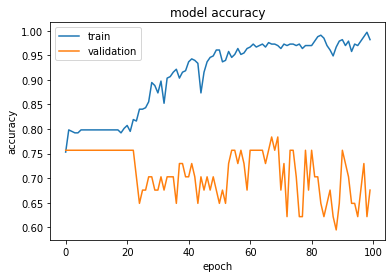

----------------------------------------------------------------------------------------------------


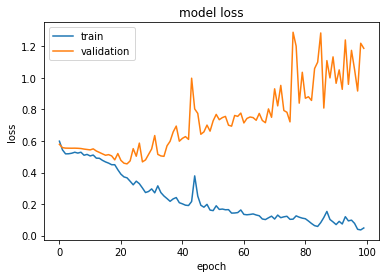

----------------------------------------------------------------------------------------------------


In [ ]:
get_results(sequence_model,history)